In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from asteroid.models.base_models import BaseModel
import numpy as np
import pandas as pd
import librosa as lr
import librosa.display as lrd
import soundfile as sf
import matplotlib.pyplot as plt
import time
import os
import os.path
import sys

from pathlib import PurePath
from librosa import display as lrd
from concurrent.futures import ProcessPoolExecutor
from collections import OrderedDict
from functools import partial
from torch.multiprocessing import Process, Queue, cpu_count
from queue import Empty

from torch.utils.data import DataLoader, ConcatDataset, random_split, Subset
from asteroid.data import TimitDataset
from asteroid.data.utils import CachedWavSet, FixedMixtureSet
from tqdm import trange, tqdm

from asteroid import DCUNet, RegressionFCNN, WaveUNet, DPTNet, SMoLnet, Phasen

from asteroid.masknn import UNetGANGenerator, UNetGANDiscriminator
from asteroid.utils.notebook_utils import show_wav

sys.path.append('../egs')

from timit_drones.evaluate import evaluate_model, eval_all, eval_all_and_plot, model_labels, metrics_names, model_colors
from timit_drones.evaluate import plot_single, aggregate_results

%load_ext autoreload
%autoreload 2

In [2]:
TIMIT_DIR_8kHZ = '../../../datasets/TIMIT'
TEST_NOISE_DIR = '../../../datasets/noises/noises-test-drones'
SUBJ_EVAL_OUT = '../../../datasets/drone_noises_out'
SAMPLE_RATE    = 8000
SUBJ_TEST_SNRS = [-25, -20, -15, -10]
SEED           = 42

In [3]:
def get_timit_small(timit_dir, test_noise_dir, sample_rate=8000,
                    test_snrs=[-30, -25, -20, -15, -10, -5, 0], seed=42, num_clean=15):
    timit_test_clean = TimitDataset(timit_dir, subset='test', sample_rate=sample_rate)
    
    np.random.seed(seed)
    chosen_idxs = np.random.choice(np.arange(len(timit_test_clean)), num_clean, replace=True)
    timit_small = Subset(timit_test_clean, chosen_idxs)
    noises_test = CachedWavSet(test_noise_dir, sample_rate=sample_rate, precache=True, with_path=True)
    
    return FixedMixtureSet(timit_small, noises_test, snrs=test_snrs, random_seed=seed, with_snr=True)

In [4]:
timit_test_small = get_timit_small(TIMIT_DIR_8kHZ, TEST_NOISE_DIR, SAMPLE_RATE, SUBJ_TEST_SNRS, SEED)

Precaching audio: 100%|██████████| 2/2 [00:00<00:00, 329.06it/s]


In [5]:
models = {
    'Noisy': None,
    'RegressionFCNN': RegressionFCNN.from_pretrained('../../../workspace/models/baseline_model_v1.pt'),
    'DCUNet': DCUNet.from_pretrained('../../../workspace/models/dcunet_20_random_v2.pt', fix_length_mode="pad"),
    'WaveUNet': WaveUNet.from_pretrained('../../../workspace/models/waveunet_model_adapt.pt'),
    'SMoLnet': SMoLnet.from_pretrained('../../../workspace/models/SMoLnet.pt'),
    'DPTNet': DPTNet.from_pretrained('../../../workspace/models/dptnet_model.pt'),
}

In [6]:
def mixture_name(clean, noisy, prefix):
    clean = PurePath(clean)
    noisy = PurePath(noisy)
    clean_last = clean.stem.split('.')[0]
    clean_id = f'{clean.parts[-3]}-{clean.parts[-2]}-{clean_last}'
    return f'{prefix}_{clean_id}.{noisy.stem}.wav'

In [19]:
def normalize_volume(wav):
    max_amp = np.max(wav)
    coeff = 1. / max_amp
    return wav * coeff

### Copy clean data

In [21]:
clean_dir = os.path.join(SUBJ_EVAL_OUT, 'Clean')
os.makedirs(clean_dir, exist_ok=True)

for i in range(30):
    _, clean, snr, clean_path, noisy_path = timit_test_small[i]
    clean_name = mixture_name(clean_path, noisy_path, 'clean')
    out_path = os.path.join(clean_dir, clean_name)
    sf.write(out_path, normalize_volume(clean.numpy()), samplerate=SAMPLE_RATE)

### Copy noisy data/models data

In [22]:
with torch.no_grad():
    for name, model in models.items():
        print(f'Generating for {name}')
        model_dir = os.path.join(SUBJ_EVAL_OUT, name)
        for snr in SUBJ_TEST_SNRS:
            os.makedirs(os.path.join(model_dir, f'{snr}dB'), exist_ok=True)
            
        if model is not None:
            model = model.cuda()
            model.eval()
        
        for i in trange(len(timit_test_small)):
            mix, clean, snr, clean_path, noisy_path = timit_test_small[i]
            enh_name = mixture_name(clean_path, noisy_path, name)
            out_path = os.path.join(model_dir, f'{snr}dB', enh_name)
            
            if model is not None:
                mix = mix.cuda()
                enh = model(mix).detach().flatten().cpu().numpy()
            else:
                enh = mix.numpy()
            
            sf.write(out_path, normalize_volume(enh), samplerate=SAMPLE_RATE)
            

 28%|██▊       | 34/120 [00:00<00:00, 337.71it/s]

Generating for Noisy


 14%|█▍        | 17/120 [00:00<00:00, 168.58it/s]

Generating for RegressionFCNN


  3%|▎         | 4/120 [00:00<00:03, 31.11it/s]

Generating for DCUNet


 10%|█         | 12/120 [00:00<00:00, 112.63it/s]

Generating for WaveUNet


 12%|█▎        | 15/120 [00:00<00:00, 138.67it/s]

Generating for SMoLnet


  2%|▎         | 3/120 [00:00<00:05, 20.84it/s]

Generating for DPTNet


100%|██████████| 120/120 [00:06<00:00, 19.16it/s]


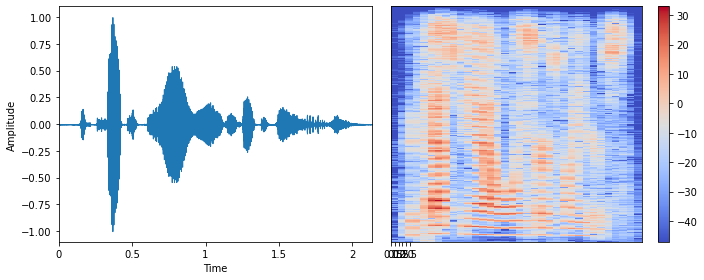

In [23]:
clean_dir = os.path.join(SUBJ_EVAL_OUT, 'Clean')
files = os.listdir(clean_dir)
sample_file = files[0]
wav, _ = lr.load(os.path.join(clean_dir, sample_file), sr=SAMPLE_RATE)
show_wav(wav)

Noisy, -25dB


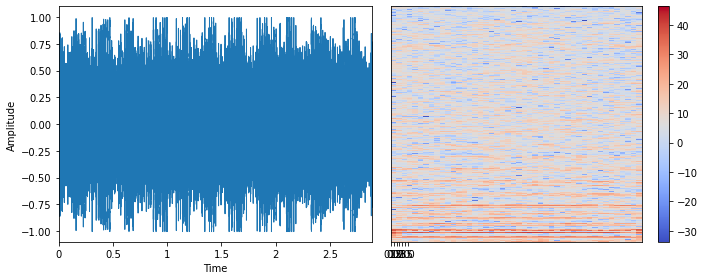

Noisy, -20dB


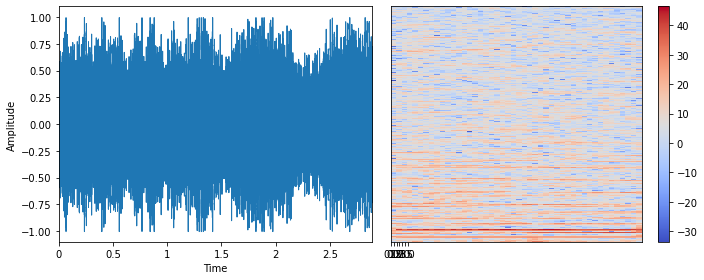

Noisy, -15dB


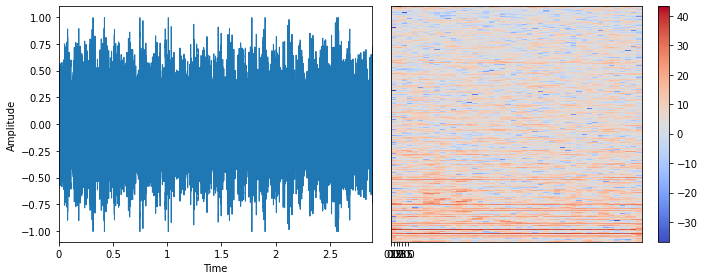

Noisy, -10dB


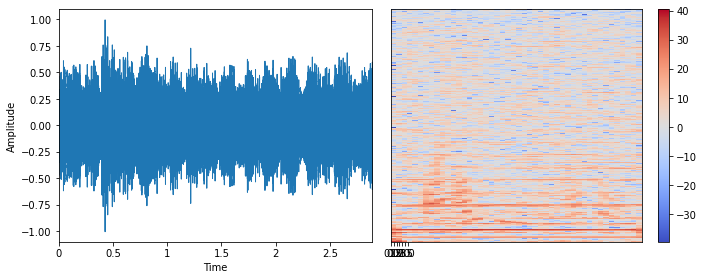

RegressionFCNN, -25dB


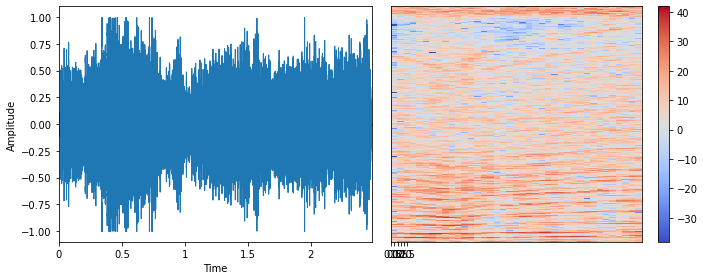

RegressionFCNN, -20dB


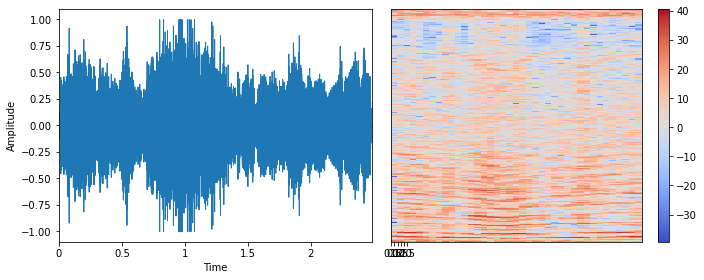

RegressionFCNN, -15dB


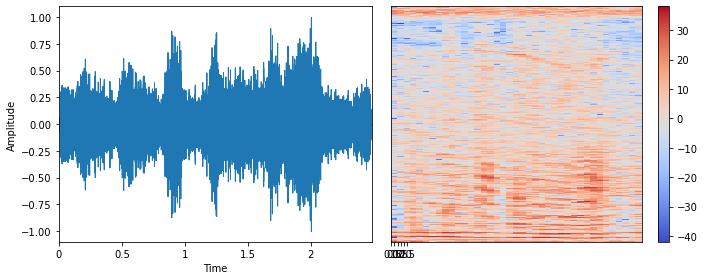

RegressionFCNN, -10dB


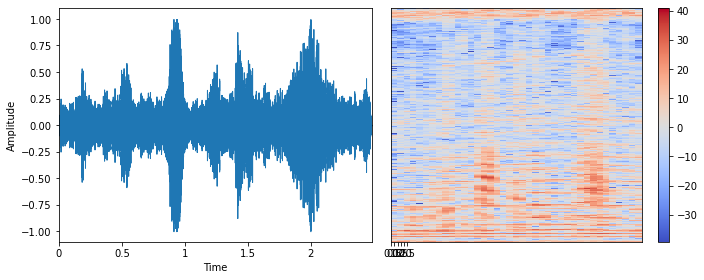

DCUNet, -25dB


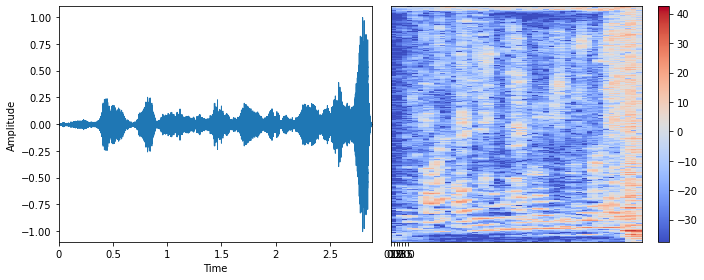

DCUNet, -20dB


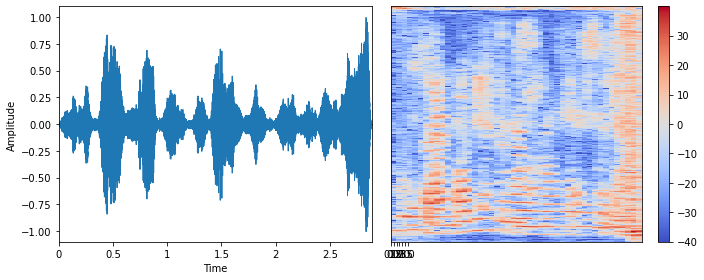

DCUNet, -15dB


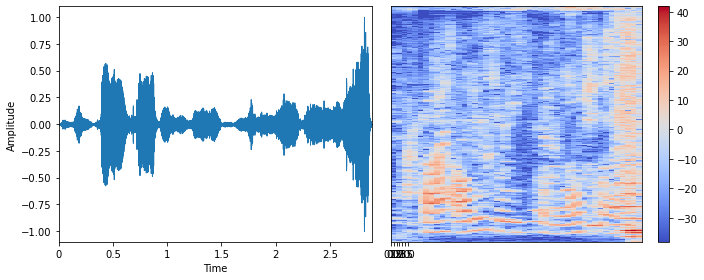

DCUNet, -10dB


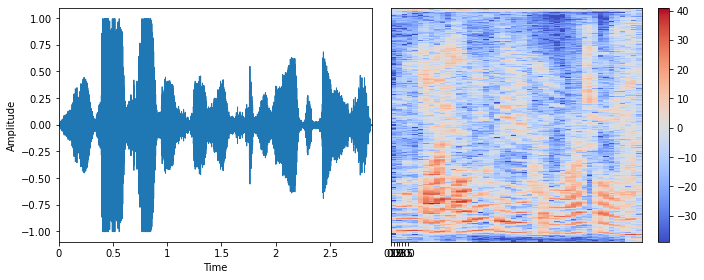

WaveUNet, -25dB


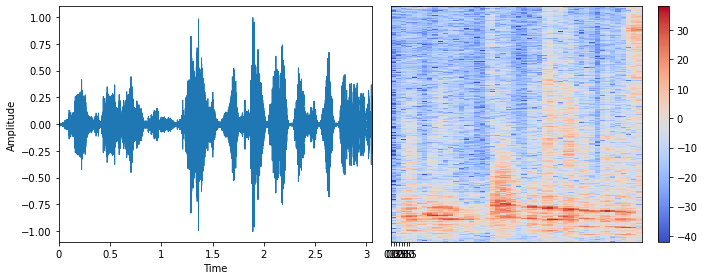

WaveUNet, -20dB


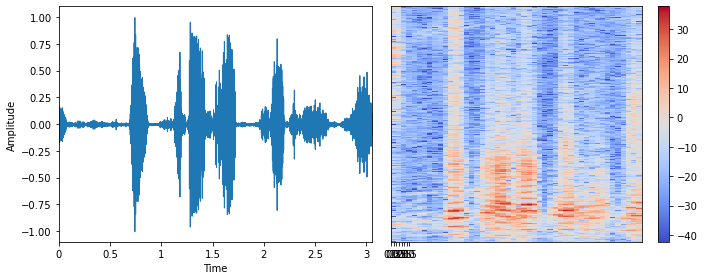

WaveUNet, -15dB


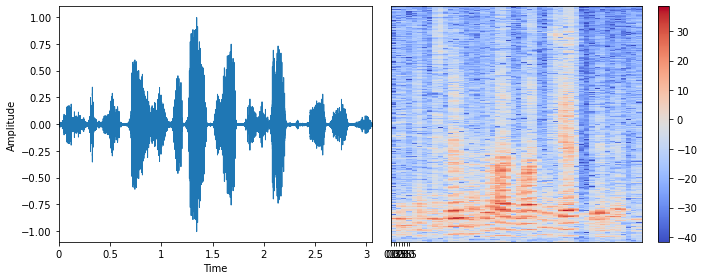

WaveUNet, -10dB


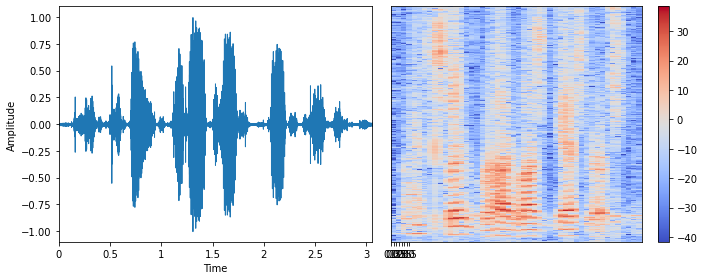

SMoLnet, -25dB


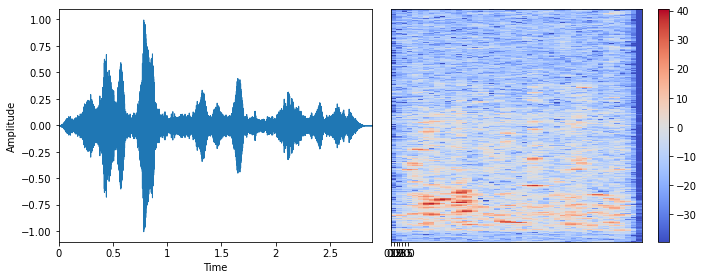

SMoLnet, -20dB


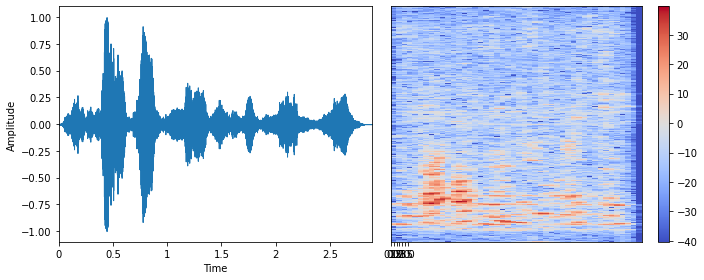

SMoLnet, -15dB


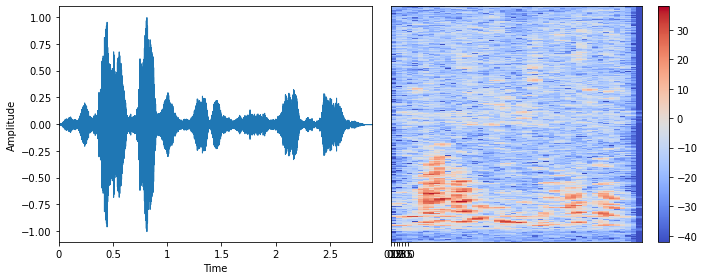

SMoLnet, -10dB


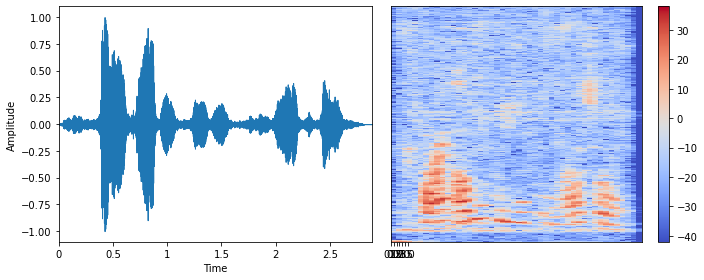

DPTNet, -25dB


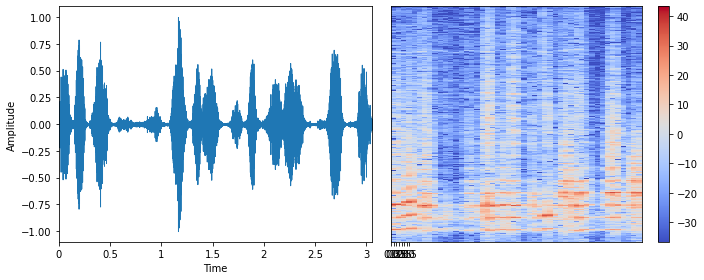

DPTNet, -20dB


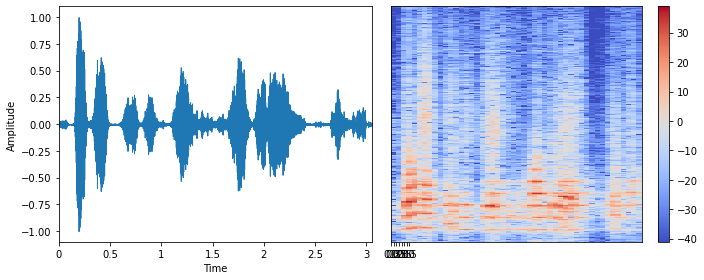

DPTNet, -15dB


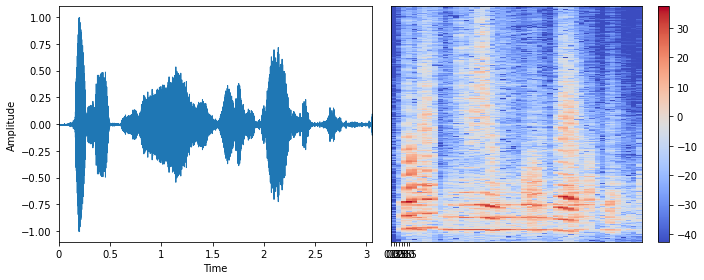

DPTNet, -10dB


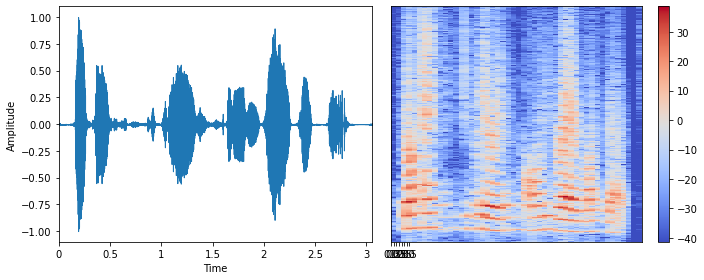

In [24]:
for name in models.keys():
    model_dir = os.path.join(SUBJ_EVAL_OUT, name)
    for snr in SUBJ_TEST_SNRS:
        snr_dir = os.path.join(model_dir, f'{snr}dB')
        files = os.listdir(snr_dir)
        sample_file = files[0]
        wav, _ = lr.load(os.path.join(snr_dir, sample_file), sr=SAMPLE_RATE)
        print(f'{name}, {snr}dB')
        show_wav(wav)